In [1]:
import json

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import Input
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, UpSampling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
# define hyperparameters
NUM_CLASSES = 10
EPOCH = 20
BATCH_SIZE = 128
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']
# resize
img_rows = img_cols = 32
channels = 3
SCALE = 7

In [3]:
#load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.3
)

In [5]:
# data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [6]:
# preprocessing data for ResNet50
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [7]:
# labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [8]:
# load ResNet50
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows*SCALE, img_cols*SCALE, 3))
resnet50_base.trainable = True

In [9]:
# frize layouts
for layer in resnet50_base.layers:
    layer.trainable = False

In [10]:
image_input = Input(shape=(img_rows, img_cols, 3))

In [11]:
# add layouts for learning
addtrain_model = Sequential([
    image_input,
    UpSampling2D(size=(SCALE, SCALE)),
    resnet50_base,
    GlobalAveragePooling2D(name='avg_pool'),
    Flatten(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax"),
])

In [12]:
# compile model
addtrain_model.compile(
    optimizer=OPTIMIZER(learning_rate=LEARNING_RATE),
    loss=LOSS,
    metrics=METRICS)

addtrain_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2

In [13]:
# add callbacks
checkpoint = ModelCheckpoint("cifar10_best_result1.h5", save_best_only=True)
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [14]:
# train with image augmentation
history = addtrain_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                             steps_per_epoch=len(X_train) / BATCH_SIZE, epochs=EPOCH,
                             validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])

Epoch 1/20
390/390 [==============================] - 102s 231ms/step - loss: 1.1612 - accuracy: 0.6068 - val_loss: 0.8573 - val_accuracy: 0.7087
Epoch 2/20
390/390 [==============================] - 90s 230ms/step - loss: 0.8511 - accuracy: 0.7036 - val_loss: 0.7454 - val_accuracy: 0.7525
Epoch 3/20
390/390 [==============================] - 91s 232ms/step - loss: 0.7765 - accuracy: 0.7307 - val_loss: 0.6661 - val_accuracy: 0.7754
Epoch 4/20
390/390 [==============================] - 91s 232ms/step - loss: 0.7258 - accuracy: 0.7473 - val_loss: 0.6477 - val_accuracy: 0.7814
Epoch 5/20
390/390 [==============================] - 91s 232ms/step - loss: 0.6985 - accuracy: 0.7569 - val_loss: 0.6223 - val_accuracy: 0.7921
Epoch 6/20
390/390 [==============================] - 91s 232ms/step - loss: 0.6783 - accuracy: 0.7641 - val_loss: 0.6112 - val_accuracy: 0.7927
Epoch 7/20
390/390 [==============================] - 91s 232ms/step - loss: 0.6554 - accuracy: 0.7710 - val_loss: 0.6074 - val_a

In [15]:
results = addtrain_model.evaluate(X_test, y_test)
results

313/313 [==============================] - 17s 55ms/step - loss: 0.5413 - accuracy: 0.8233


[0.5413421392440796, 0.8233000040054321]

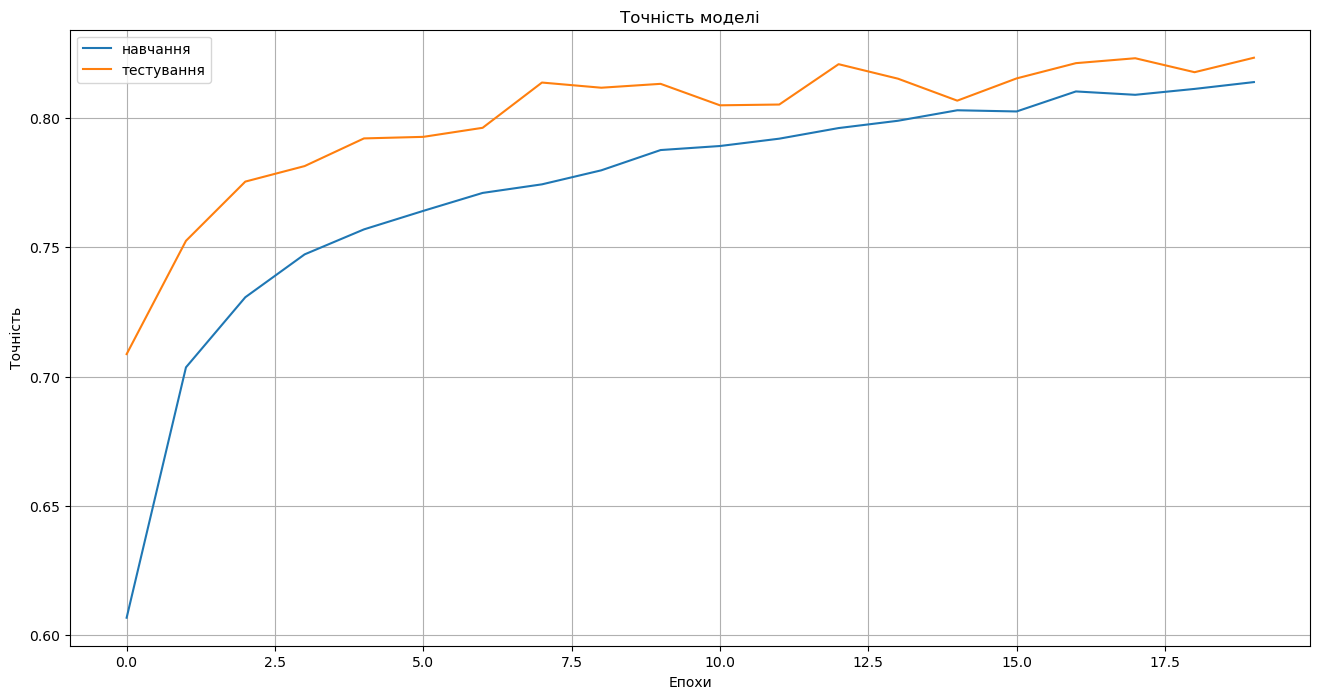

In [16]:
# plotting function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Точність моделі')
    plt.ylabel('Точність')
    plt.xlabel('Епохи')
    plt.legend(['навчання', 'тестування'], loc='upper left')
    plt.grid()
    plt.savefig('hystory.png')
    plt.show()


plothist(history)

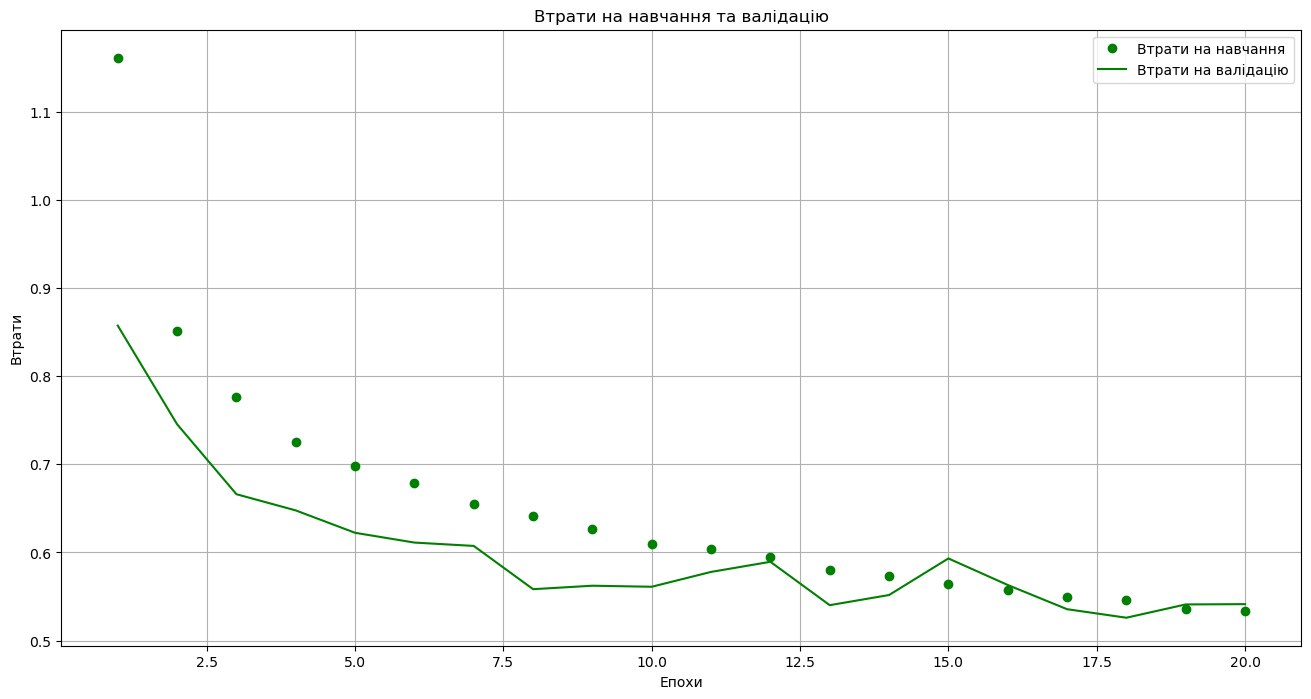

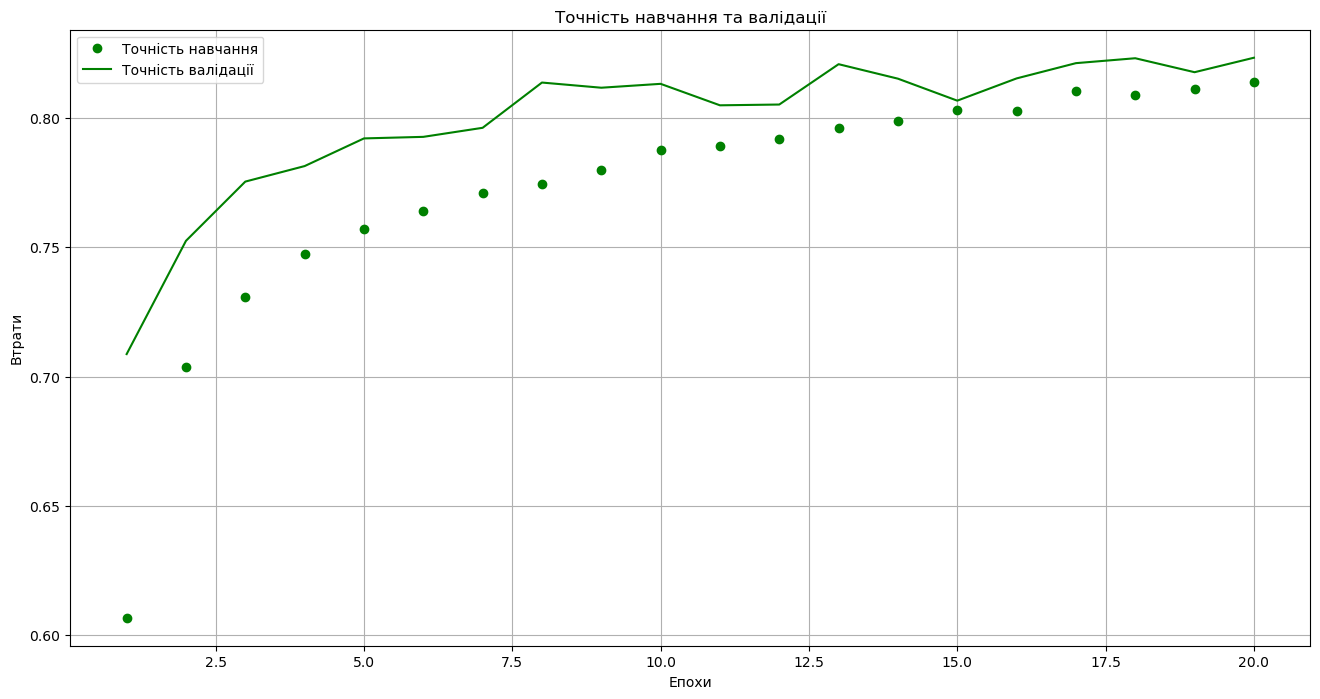

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(epochs, loss_values, 'go', label='Втрати на навчання')
plt.plot(epochs, val_loss_values, 'g', label='Втрати на валідацію')
plt.title('Втрати на навчання та валідацію')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid()
plt.savefig('Training and validation loss.png')
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Точність навчання')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Точність валідації')
plt.title('Точність навчання та валідації')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid()
plt.savefig('Training and validation accuracy.png')
plt.show()

In [18]:
addtrain_model.save("cifar10_best1.h5")

In [19]:
addtrain_model.save("cifar10_best1.hdf5")

In [20]:
addtrain_model.save_weights("cifar10_best1.h5")

In [ ]:
# save hyperparameters
params = {
    'dataset': 'cifar10',
    'model_name': 'ResNet50',
    'resize': f'32x32x3 to {img_rows}x{img_cols}x3',
    'trainable_model_layers': '10',
    'additional_layers': ['Flatten', 'Dense(512, activation="relu")', 'BatchNormalization()', 'Dropout(0.2)',
                          'Dense(num_classes, activation="softmax")'],
    'num_classes': NUM_CLASSES,
    'epochs': EPOCH,
    'batch_size': BATCH_SIZE,
    'optimizer': f'{OPTIMIZER}',
    'learning_rate': LEARNING_RATE,
    'loss': LOSS,
    'metrics': METRICS,
    'hystory': history.history,
    'model_test_acc': results

}

# write to JSON
json_string = json.dumps(params)
with open('model_data.json', 'w') as f:
    f.write(json_string)